In [1]:
import numpy as np
import gym
from gym import Env, spaces, utils
import pygame
from typing import Optional
from io import StringIO
from contextlib import closing
from gym.spaces import Discrete
from gym.wrappers import FlattenObservation
import os

https://github.com/tensorflow/agents/blob/master/docs/tutorials/9_c51_tutorial.ipynb

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay


from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, q_network
from tf_agents.policies import random_tf_policy, greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

import tensorflow as tf

In [3]:
from env_2048 import *

In [4]:
# from IPython.display import clear_output
# env = BlockDoubleEnv()
# env.reset()  # reset enviornment to default state
# score = 0
# while True:
#     check = 0
#     print(env.render())
#     key = input("w,a,s,d\n").lower()
#     if key == "w":
#         action = 3
#     elif key == "d":
#         action = 0
#     elif key == "s":
#         action = 1
#     elif key == "a":
#         action = 2
#     else:
#         break
#     clear_output()
#     new_state, reward, done, info = env.step(action)

### Hyperparamaters

In [5]:
num_iterations = 100 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [6]:
env = BlockDoubleEnv()

In [7]:
train_py_env = suite_gym.wrap_env(BlockDoubleEnv())
eval_py_env = suite_gym.wrap_env(BlockDoubleEnv())
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [8]:
from tensorflow.keras.layers import Rescaling
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers = Rescaling(scale=1./2048),
    #num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [9]:
train_env.observation_spec()

BoundedTensorSpec(shape=(16,), dtype=tf.int32, name='observation', minimum=array(0), maximum=array(2048))

In [10]:
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
fc_layer_params = (100, )
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

from tensorflow.keras.layers import Reshape, Conv2D, Flatten

reshape = [Reshape((4, 4), input_shape=(16,))]
NUM_FILTERS_LAYER_1 = 32 # number of filters in 1st layer
NUM_FILTERS_LAYER_2 = 64 # number of filters in 2nd layer
FILTERS_SIZE_LAYER_1 = 3 # Filter Size = 3 x 3
FILTERS_SIZE_LAYER_2 = 1 # Filter Size = 1 x 1
STRIDES_LAYER_1 = (2, 2)
STRIDES_LAYER_2 = (1, 1)
ACTIVATION_FTN_CNN = 'relu'
# Dense Layers:
NUM_DENSE_NEURONS = 512
ACTIVATION_FTN_DENSE = 'relu'
ACTIVATION_FTN_OUTPUT = 'linear'
INPUT_SHAPE_CNN = (1,4,4)  
conv_layers = [ Conv2D(filters=NUM_FILTERS_LAYER_1,
                    kernel_size=FILTERS_SIZE_LAYER_1,
                    strides=STRIDES_LAYER_1,
                    padding='valid',
                    activation=ACTIVATION_FTN_CNN,
                    input_shape=INPUT_SHAPE_CNN), #, data_format=data_format)) 
Conv2D(filters=NUM_FILTERS_LAYER_2,
                    kernel_size=FILTERS_SIZE_LAYER_2,
                    strides=STRIDES_LAYER_2,
                    padding='valid',
                    activation=ACTIVATION_FTN_CNN,
                    input_shape=INPUT_SHAPE_CNN)
]
q_net = sequential.Sequential([Rescaling(scale=1./2048)]  + reshape + conv_layers + [Flatten()] +  dense_layers + [q_values_layer])

In [11]:
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
fc_layer_params = (1024, 512, 256)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

from tensorflow.keras.layers import Reshape, Conv2D, Flatten

reshape = [Reshape((4, 4 ,1), input_shape=(16,))]

conv_layers = [ Conv2D(filters=32, kernel_size=3, input_shape=(1,4,4)), Conv2D(filters=64, kernel_size=1, input_shape=(1,4,4))]
q_net = sequential.Sequential([Rescaling(scale=1./2048)] + reshape  + conv_layers + [Flatten()] +  dense_layers + [q_values_layer])

In [12]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_net,
    # categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    # min_q_value=min_q_value,
    # max_q_value=max_q_value,
    
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [13]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    score = time_step.observation.numpy().sum()
  avg_score = score / num_episodes
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], avg_score

def compute_avg_score(environment, policy, num_episodes=10):

  total_score = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_score = 0.0

    while time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_score += time_step._get_info[0]
    total_score += episode_score

  avg_return = total_score / num_episodes
  return avg_return.numpy()[0]

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see t

50.0

In [30]:
environment = eval_env
policy = agent.policy 

total_return = 0.0

time_step = environment.reset()
episode_return = 0.0
print("START")
while not time_step.is_last():
  print(time_step.observation)
  action_step = policy.action(time_step)
  time_step = environment.step(action_step.action)
  episode_return += time_step.reward
total_return += episode_return

avg_return.numpy()[0]

START
tf.Tensor([[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 2]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 4]], shape=(1, 16), dtype=int32)
tf.Tensor([[2 0 0 0 0 0 0 0 4 0 0 0 4 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[2 0 0 2 0 0 0 0 0 0 0 4 0 0 0 4]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 0 0 0 0 2 0 0 0 0 2 2 0 0 8]], shape=(1, 16), dtype=int32)
tf.Tensor([[2 0 2 2 0 0 0 8 0 0 0 0 0 0 0 2]], shape=(1, 16), dtype=int32)
tf.Tensor([[2 0 2 2 0 0 0 8 2 0 0 2 0 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 2 4 0 0 0 8 2 0 0 4 0 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[2 0 2 4 0 0 0 8 0 0 2 4 0 0 0 0]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 2 0 0 0 0 4 0 0 0 8 2 0 4 4]], shape=(1, 16), dtype=int32)
tf.Tensor([[0 0 0 2 0 0 2 4 0 0 0 8 0 0 2 8]], shape=(1, 16), dtype=int32)
tf.Tensor([[ 0  0  

292.4

64

In [15]:
compute_avg_return(eval_env, agent.policy, 2)

0.0

In [16]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [18]:
#@test {"skip": true}
try:
  %%time
except:
  pass
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_score = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
for _ in range(num_iterations):
  #print(_)
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    #print(_)
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return, avg_score = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f} Average Score = {1:.2f}'.format(step, avg_return, avg_score))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 242.02471923828125
step = 400: loss = 477.23846435546875
step = 600: loss = 257.37615966796875
step = 800: loss = 2576.6806640625
step = 1000: loss = 1498.20849609375
step = 1000: Average Return = 6.40
step = 1200: loss = 514.2685546875
step = 1400: loss = 346.1334228515625
step = 1600: loss = 703.2884521484375
step = 1800: loss = 530.3494873046875
step = 2000: loss = 361.6815490722656
step = 2000: Average Return = 1.20
step = 2200: loss = 597.1474609375
step = 2400: loss = 814.6648559570312
step = 2600: loss = 1417.0101318359375
step = 2800: loss = 2719.98876953125
step = 3000: loss = 1820.596435546875
step = 3000: Average Return = 74.00
step = 3200: loss = 2099.7900390625
step = 3400: loss = 1651.3359375
step = 3600: loss = 1061.496582

In [21]:
num_iterations = 90000
for _ in range(num_iterations):
  #print(_)
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    #print(_)
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

step = 40200: loss = 2581.43408203125
step = 40400: loss = 2451.46337890625
step = 40600: loss = 1150.9716796875
step = 40800: loss = 2123.978515625
step = 41000: loss = 1275.426513671875
step = 41000: Average Return = 270.80
step = 41200: loss = 1845.7103271484375
step = 41400: loss = 2367.851806640625
step = 41600: loss = 2475.6123046875
step = 41800: loss = 2100.190673828125
step = 42000: loss = 1361.25927734375
step = 42000: Average Return = 335.20
step = 42200: loss = 799.846923828125
step = 42400: loss = 3115.971923828125
step = 42600: loss = 3633.2626953125
step = 42800: loss = 3144.14111328125
step = 43000: loss = 1674.4761962890625
step = 43000: Average Return = 241.20
step = 43200: loss = 2088.58935546875
step = 43400: loss = 1814.13525390625
step = 43600: loss = 2128.239501953125
step = 43800: loss = 2347.887451171875
step = 44000: loss = 2365.337158203125
step = 44000: Average Return = 289.20
step = 44200: loss = 6664.958984375
step = 44400: loss = 2335.933349609375
step = 

Text(0.5, 0, 'Step')

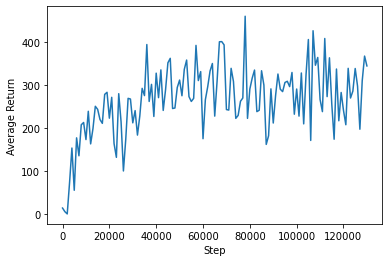

In [22]:
steps = range(0, step + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')


In [28]:
time_step = eval_env.reset()

In [ ]:
def compute_avg_score(environment, policy, num_episodes=10):

  total_score = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_score = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_score += time_step._get_info[0]
    total_score += episode_score

  avg_return = total_score / num_episodes
  return avg_return.numpy()[0]

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

NeedDownloadError: Need ffmpeg exe. You can obtain it with either:
  - install using conda: conda install ffmpeg -c conda-forge
  - download using the command: imageio_download_bin ffmpeg
  - download by calling (in Python): imageio.plugins.ffmpeg.download()
